In [1]:
import gym
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
env_name = 'Skiing-v0'

In [3]:
env = gym.make(env_name)
N = 10000

[2017-02-10 11:18:20,768] Making new env: Skiing-v0


In [4]:
buf = []
use = []

In [5]:
alpha = 0.6
sz = 28
while len(buf) < N:
    observation = env.reset()
    observation = cv2.resize(observation, (sz, sz))
    prev_delta = np.zeros((3, sz, sz))
    for t in range(3000):
        use_ = 0
        if t >= 2:
            use_ = 1
        use.append(use_)
        
        prev_observation = observation
        
        action = env.action_space.sample()
        observation, r, done, i = env.step(action)
        observation = cv2.resize(observation, (sz, sz))
        
        delta_now = observation - prev_observation
        delta_now = np.swapaxes(delta_now, 0, 2)
        delta_now = np.swapaxes(delta_now, 1, 2)
        delta = alpha * delta_now + (1 - alpha) * prev_delta
        prev_delta = delta
        buf.append(delta)
        
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break

Episode finished after 1669 timesteps
Episode finished after 1710 timesteps
Episode finished after 1877 timesteps
Episode finished after 2388 timesteps
Episode finished after 1458 timesteps
Episode finished after 1123 timesteps


In [6]:
images = np.array(buf)
images = images.reshape(-1, 3, sz, sz)
use = np.array(use)

In [7]:
images.shape

(10225, 3, 28, 28)

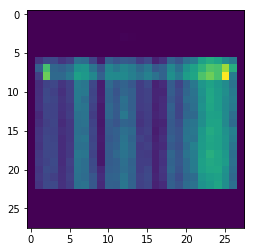

In [8]:
mean = np.mean(images, axis = 0)
plt.imshow(mean[0,:,:])

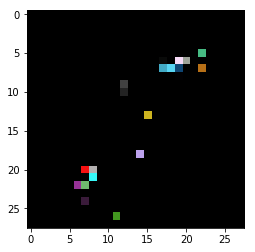

In [12]:
i = 180
plt.imshow(np.swapaxes(images[i], 0, 2))

In [13]:
import os, sys, urllib, gzip
from __future__ import print_function
try:
    import cPickle as pickle
except:
    import pickle
sys.setrecursionlimit(10000)

In [14]:
import matplotlib
matplotlib.use('Agg') # Change matplotlib backend, in case we have no X server running..
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from IPython.display import Image as IPImage
from PIL import Image

/home/etoestja/venv/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [15]:
from lasagne.layers import get_output, InputLayer, DenseLayer, Upscale2DLayer, ReshapeLayer
from lasagne.nonlinearities import rectify, leaky_rectify, tanh
from lasagne.updates import nesterov_momentum
from lasagne.objectives import categorical_crossentropy
from nolearn.lasagne import NeuralNet, BatchIterator, PrintLayerInfo

Using gpu device 1: GeForce GTX 980 (CNMeM is disabled, cuDNN 5105)
/home/etoestja/venv/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
/home/etoestja/venv/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [16]:
from lasagne.layers import Conv2DLayer as Conv2DLayerSlow
from lasagne.layers import MaxPool2DLayer as MaxPool2DLayerSlow
#try:
from lasagne.layers.cuda_convnet import Conv2DCCLayer as Conv2DLayerFast
from lasagne.layers.cuda_convnet import MaxPool2DCCLayer as MaxPool2DLayerFast
print('Using cuda_convnet (faster)')
#except ImportError:
#    from lasagne.layers import Conv2DLayer as Conv2DLayerFast
#    from lasagne.layers import MaxPool2DLayer as MaxPool2DLayerFast
#    print('Using lasagne.layers (slower)')

Using cuda_convnet (faster)


In [17]:
X = np.array(images, dtype=np.float32) / 255.

In [18]:
print('X type and shape:', X.dtype, X.shape)
print('X.min():', X.min())
print('X.max():', X.max())

X type and shape: float32 (10225, 3, 28, 28)
X.min(): 0.0
X.max(): 0.985528


In [19]:
# we need our target to be 1 dimensional
X_out = X.reshape((X.shape[0], -1))
print('X_out:', X_out.dtype, X_out.shape)

X_out: float32 (10225, 2352)


In [20]:
conv_num_filters = 16
filter_size = 3
pool_size = 2
encode_size = 32
dense_mid_size = 128
pad_in = 'valid'
pad_out = 'full'
layers = [
    (InputLayer, {'shape': (None, X.shape[1], X.shape[2], X.shape[3])}), 
    (Conv2DLayerFast, {'num_filters': conv_num_filters, 'filter_size': filter_size, 'pad': pad_in}),
    (Conv2DLayerFast, {'num_filters': conv_num_filters, 'filter_size': filter_size, 'pad': pad_in}),
    (MaxPool2DLayerFast, {'pool_size': pool_size}),
    (Conv2DLayerFast, {'num_filters': 2*conv_num_filters, 'filter_size': filter_size, 'pad': pad_in}),
    (MaxPool2DLayerFast, {'pool_size': pool_size}),
    (ReshapeLayer, {'shape': (([0], -1))}),
    (DenseLayer, {'num_units': dense_mid_size}),
    (DenseLayer, {'name': 'encode', 'num_units': encode_size}),
    (DenseLayer, {'num_units': dense_mid_size}),
    (DenseLayer, {'num_units': 800}),
    (ReshapeLayer, {'shape': (([0], 2*conv_num_filters, 5, 5))}),
    (Upscale2DLayer, {'scale_factor': pool_size}),
    (Conv2DLayerFast, {'num_filters': conv_num_filters, 'filter_size': filter_size, 'pad': pad_out}),
    (Upscale2DLayer, {'scale_factor': pool_size}),
    (Conv2DLayerSlow, {'num_filters': conv_num_filters, 'filter_size': filter_size, 'pad': pad_out}),
    (Conv2DLayerSlow, {'num_filters': 3, 'filter_size': filter_size, 'pad': pad_out}),
    (ReshapeLayer, {'shape': (([0], -1))}),
]

In [21]:
ae = NeuralNet(
    layers=layers,
    max_epochs=100,
    
    update=nesterov_momentum,
    update_learning_rate=0.2,
    update_momentum=0.975,
    
    regression=True,
    verbose=1
)

In [55]:
ae.fit(X, X_out)

    201     0.00140     0.00156    0.89519  1.46s
    202     0.00142     0.00158    0.89466  1.41s
    203     0.00140     0.00156    0.89814  1.41s
    204     0.00139     0.00154    0.89904  1.41s
    205     0.00138     0.00154    0.89327  1.41s
    206     0.00136     0.00154    0.88573  1.41s
    207     0.00136     0.00154    0.88327  1.42s
    208     0.00137     0.00155    0.88569  1.41s
    209     0.00138     0.00154    0.89215  1.41s
    210     0.00137     0.00154    0.89150  1.41s
    211     0.00136     0.00154    0.88662  1.42s
    212     0.00135     0.00153    0.88674  1.42s
    213     0.00135     0.00153    0.88354  1.42s
    214     0.00134     0.00152    0.88432  1.41s
    215     0.00134     0.00152    0.88010  1.42s
    216     0.00134     0.00152    0.87936  1.42s
    217     0.00134     0.00152    0.87979  1.42s
    218     0.00134     0.00151    0.88421  1.42s
    219     0.00135     0.00151    0.88987  1.42s
    220     0.00134     0.00151    0.88645  1.42s


NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f1bd029f190>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7f1bd029f090>,
     check_input=True, custom_scores=None,
     layers=[(<class 'lasagne.layers.input.InputLayer'>, {'shape': (None, 3, 28, 28)}), (<class 'lasagne.layers.cuda_convnet.Conv2DCCLayer'>, {'filter_size': 3, 'pad': 'valid', 'num_filters': 16}), (<class 'lasagne.layers.cuda_convnet.Conv2DCCLayer'>, {'filter_size': 3, 'pad': 'valid', 'num_filters': 16}...d': 'full', 'num_filters': 3}), (<class 'lasagne.layers.shape.ReshapeLayer'>, {'shape': ([0], -1)})],
     loss=None, max_epochs=100, more_params={},
     objective=<function objective at 0x7f1bd029b668>,
     objective_loss_function=<function squared_error at 0x7f1bd1bcbd70>,
     on_batch_finished=[],
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x7f1bd0242758>],
     on_training_finished=[],
     on_training_s

<module 'matplotlib.pyplot' from '/home/etoestja/venv/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

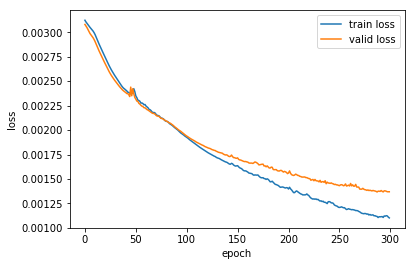

In [56]:
from nolearn.lasagne.visualize import plot_loss
plot_loss(ae)

In [57]:
save_filename = env_name + '-enc.pkl'

In [59]:
# ae.save_params_to('mnist/conv_ae.np')
pickle.dump(ae, open(save_filename,'wb'))
# ae = pickle.load(open('mnist/conv_ae.pkl','rb'))
# ae.layers

In [28]:
ae1 = pickle.load(open(save_filename,'rb'))

In [29]:
ae1.layers

[(lasagne.layers.input.InputLayer, {'shape': (None, 3, 28, 28)}),
 (lasagne.layers.cuda_convnet.Conv2DCCLayer,
  {'filter_size': 3, 'num_filters': 16, 'pad': 'valid'}),
 (lasagne.layers.cuda_convnet.Conv2DCCLayer,
  {'filter_size': 3, 'num_filters': 16, 'pad': 'valid'}),
 (lasagne.layers.cuda_convnet.MaxPool2DCCLayer, {'pool_size': 2}),
 (lasagne.layers.cuda_convnet.Conv2DCCLayer,
  {'filter_size': 3, 'num_filters': 32, 'pad': 'valid'}),
 (lasagne.layers.cuda_convnet.MaxPool2DCCLayer, {'pool_size': 2}),
 (lasagne.layers.shape.ReshapeLayer, {'shape': ([0], -1)}),
 (lasagne.layers.dense.DenseLayer, {'num_units': 128}),
 (lasagne.layers.dense.DenseLayer, {'name': 'encode', 'num_units': 32}),
 (lasagne.layers.dense.DenseLayer, {'num_units': 128}),
 (lasagne.layers.dense.DenseLayer, {'num_units': 800}),
 (lasagne.layers.shape.ReshapeLayer, {'shape': ([0], 32, 5, 5)}),
 (lasagne.layers.pool.Upscale2DLayer, {'scale_factor': 2}),
 (lasagne.layers.cuda_convnet.Conv2DCCLayer,
  {'filter_size': 3

In [60]:
X_pred = ae.predict(X).reshape(-1, 3, 28, 28)
X_pred = np.rint(256. * X_pred).astype(int)
X_pred = np.clip(X_pred, a_min = 0, a_max = 255)
X_pred = X_pred.astype('uint8')
print(X_pred.shape , X.shape)

(10225, 3, 28, 28) (10225, 3, 28, 28)


200


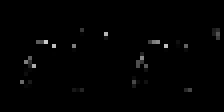

In [64]:
###  show random inputs / outputs side by side

def get_picture_array(X, rescale=4):
    array = X.reshape(3,28,28)
    array = np.clip(array, a_min = 0, a_max = 255)
    return  array.repeat(rescale, axis = 1).repeat(rescale, axis = 2).astype(np.uint8()).mean(0)

def compare_images(index):
    print(index)
    original_image = Image.fromarray(get_picture_array(255 * X[index]))
    new_size = (original_image.size[0] * 2, original_image.size[1])
    new_im = Image.new('L', new_size)
    new_im.paste(original_image, (0,0))
    rec_image = Image.fromarray(get_picture_array(X_pred[index]))
    new_im.paste(rec_image, (original_image.size[0],0))
    new_im.save('data/test.png', format="PNG")
    return IPImage('data/test.png')

compare_images(200)
# compare_images(np.random.randint(50000))